In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
from cmocean import cm
import xgcm
import xscale as xsc
import xrft

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 12

from mitequinox.utils import *
from dask import compute, delayed

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(2)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.1.23:32811 Dashboard: http://10.148.1.23:8787/status,Cluster Workers: 4 Cores: 16 Memory: 200.00 GB


_________
# 1. Read dataset


In [7]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
out_dir_mooring = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/random_location/'

In [9]:
grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_store/Grid.nc', decode_coords=True)

ds_KPP = xr.open_zarr(out_dir_zarr+'KPPhbl_total_rechunk.zarr')
ds_Eta = xr.open_zarr(out_dir_zarr+'Eta_total_rechunk.zarr')
ds_taux = xr.open_zarr(out_dir_zarr+'oceTAUX_total_rechunk.zarr')
ds_tauy = xr.open_zarr(out_dir_zarr+'oceTAUY_total_rechunk.zarr')
ds_fwflx = xr.open_zarr(out_dir_zarr+'oceFWflx_total_rechunk.zarr')
ds_qnet = xr.open_zarr(out_dir_zarr+'oceQnet_total_rechunk.zarr')
ds_qsw = xr.open_zarr(out_dir_zarr+'oceQsw_total_rechunk.zarr')
ds_sflux = xr.open_zarr(out_dir_zarr+'oceSflux_total_rechunk.zarr')
ds_us = xr.open_dataset(out_dir_zarr+'U_surface_rechunk.nc')
ds_vs = xr.open_dataset(out_dir_zarr+'V_surface_rechunk.nc')


ds_surface = xr.merge([ds_KPP,ds_Eta,ds_taux,ds_tauy,ds_fwflx,ds_qnet,ds_qsw,ds_sflux,ds_us,ds_vs,grid])
print(ds_surface)

<xarray.Dataset>
Dimensions:   (lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat       (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon       (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
  * time      (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lon_g     (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 ...
    depth     float64 0.5
  * lat_g     (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 47.49 ...
    XC        (lat, lon) float32 ...
    YC        (lat, lon) float32 ...
    XG        (lat_g, lon_g) float32 ...
    YG        (lat_g, lon_g) float32 ...
    CS        (lat, lon) float32 ...
    SN        (lat, lon) float32 ...
    Depth     (lat, lon) float32 ...
    dxC       (lat, lon_g) float32 ...
    dyC       (lat_g, lon) float32 ...
    dxG       (lat_g, lon) float32 ...
    dyG       (lat, lon_g) float32 ...
    rAz       (lat_g, lon_g) float32 ...
    rAw       (l

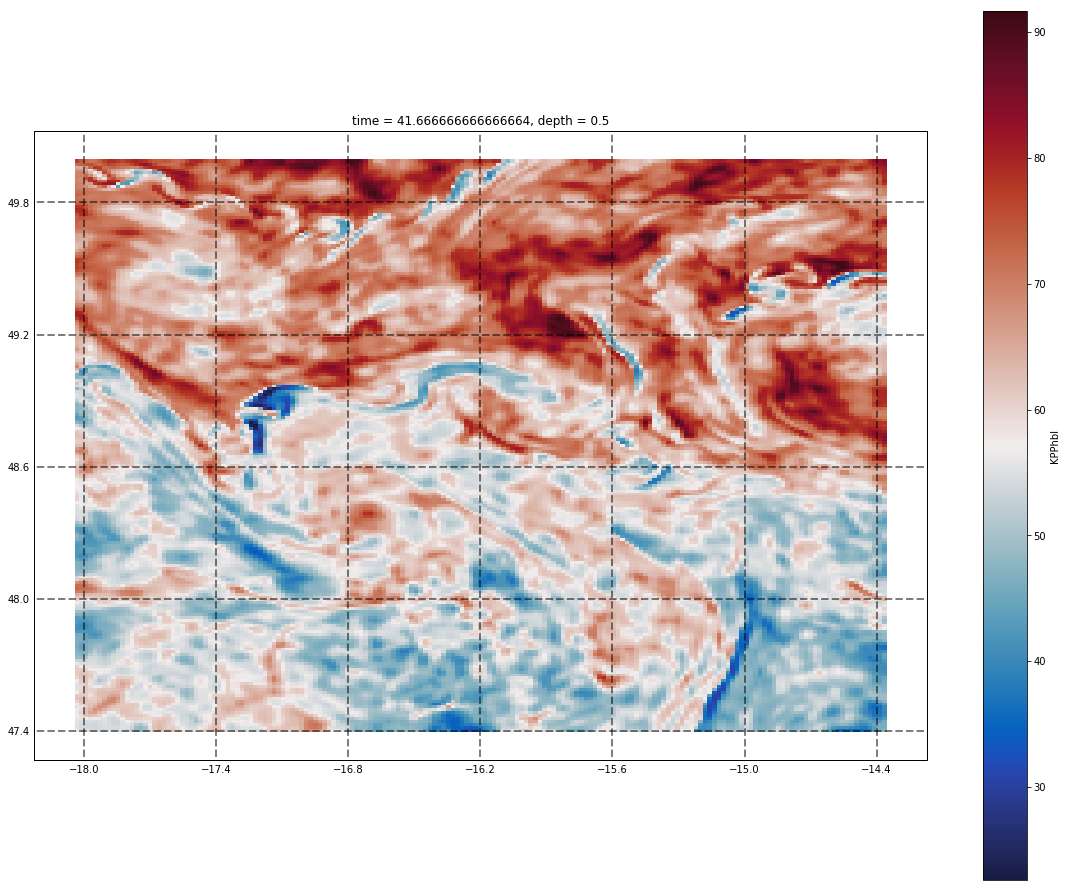

In [20]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_surface.KPPhbl.isel(time=1000).plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

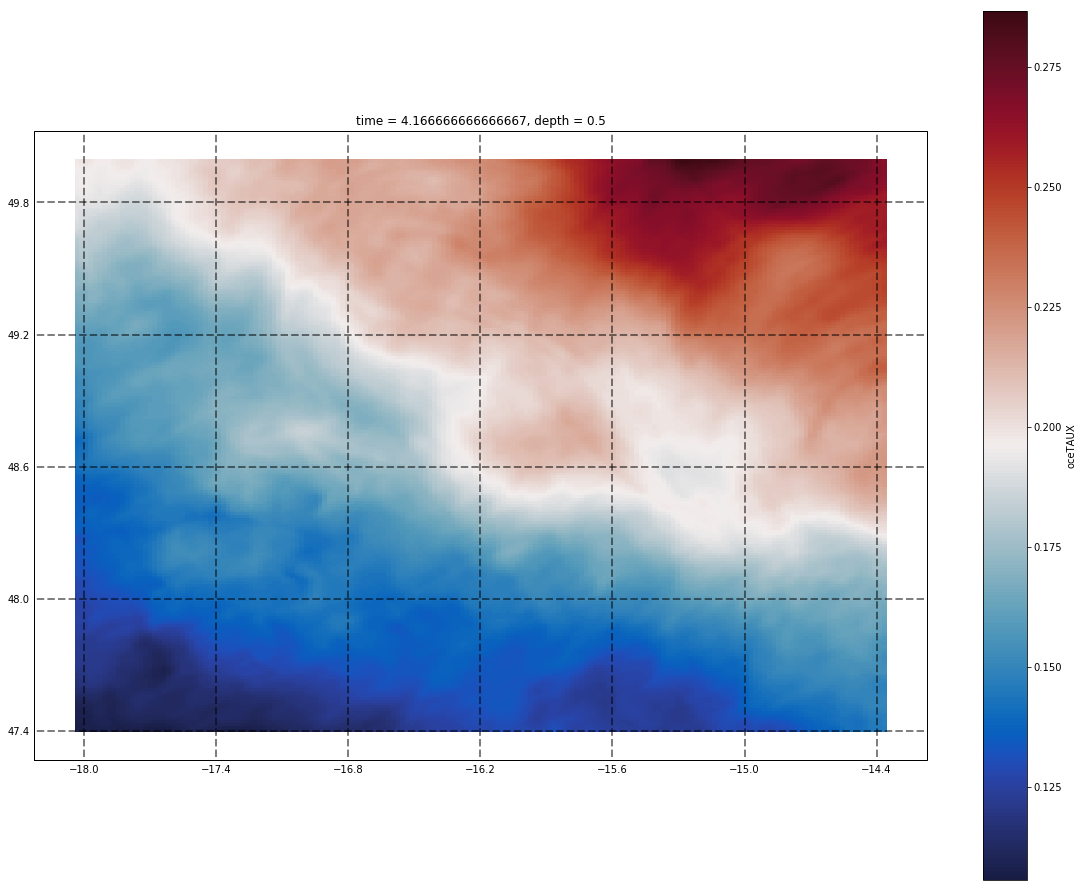

In [22]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_surface.oceTAUX.isel(time=100).plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

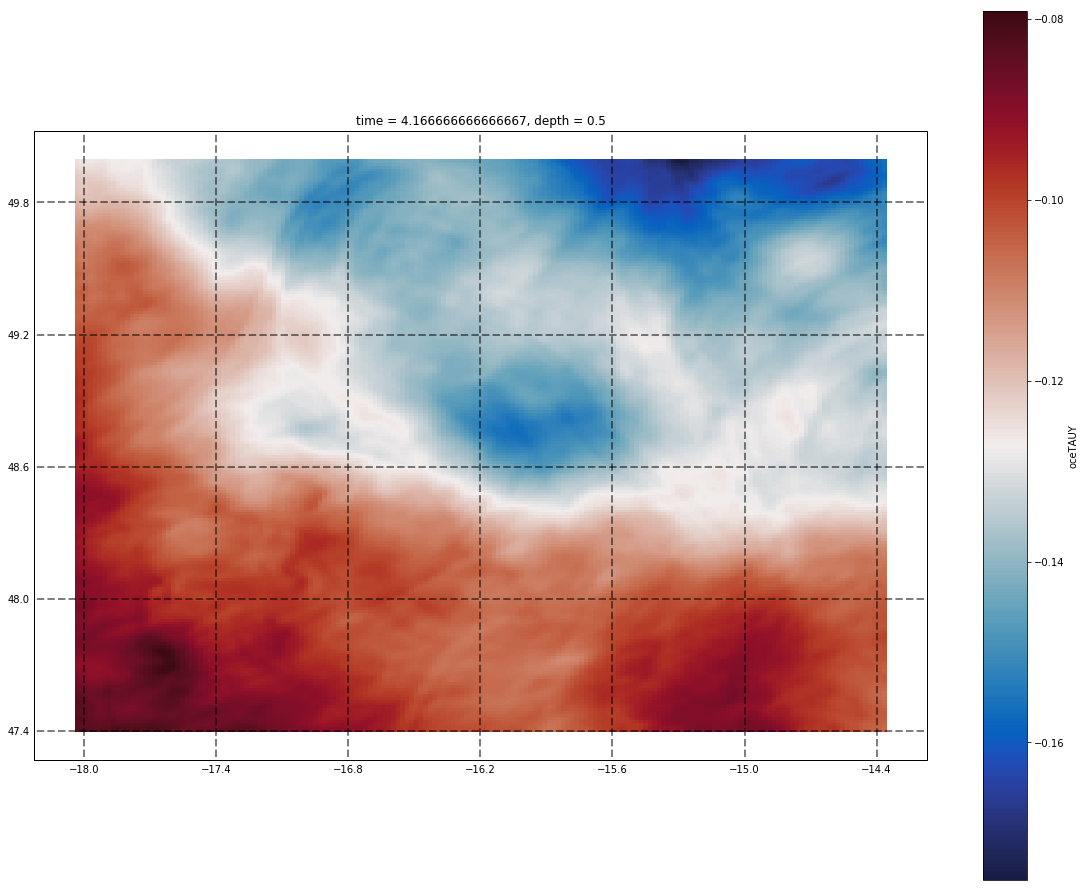

In [23]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_surface.oceTAUY.isel(time=100).plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

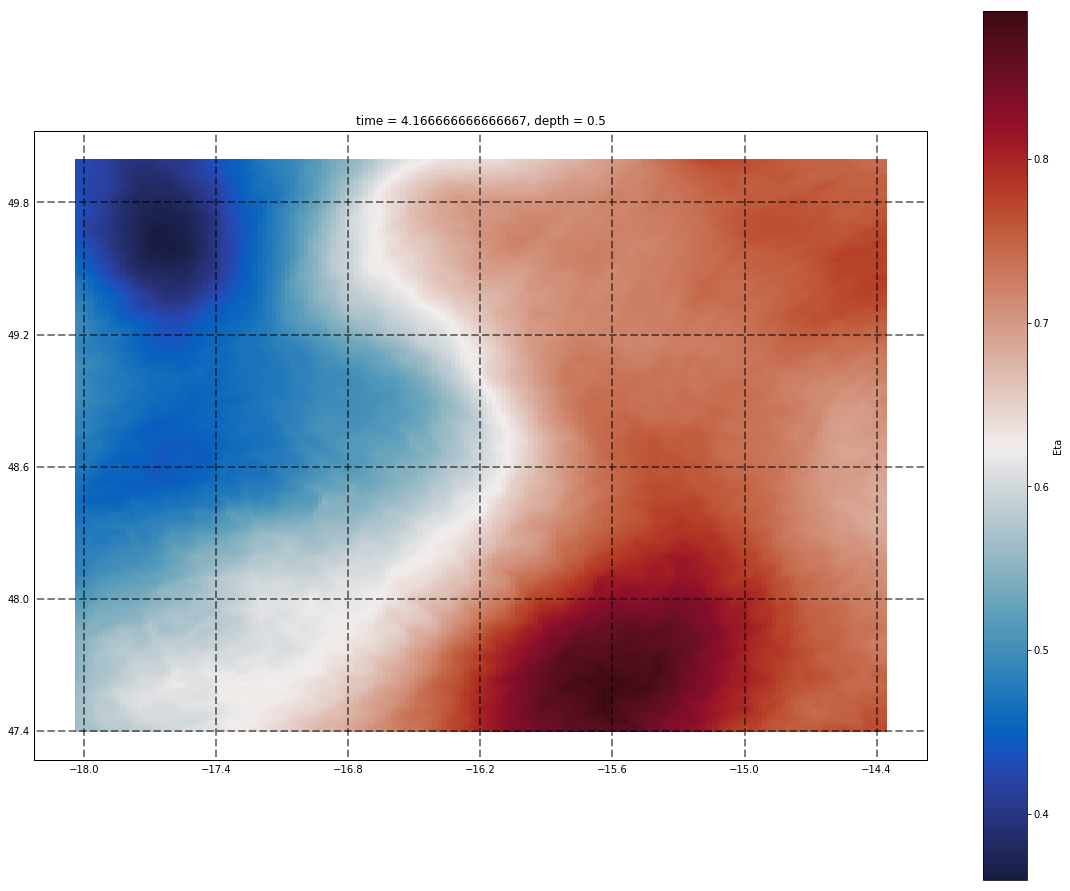

In [24]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_surface.Eta.isel(time=100).plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

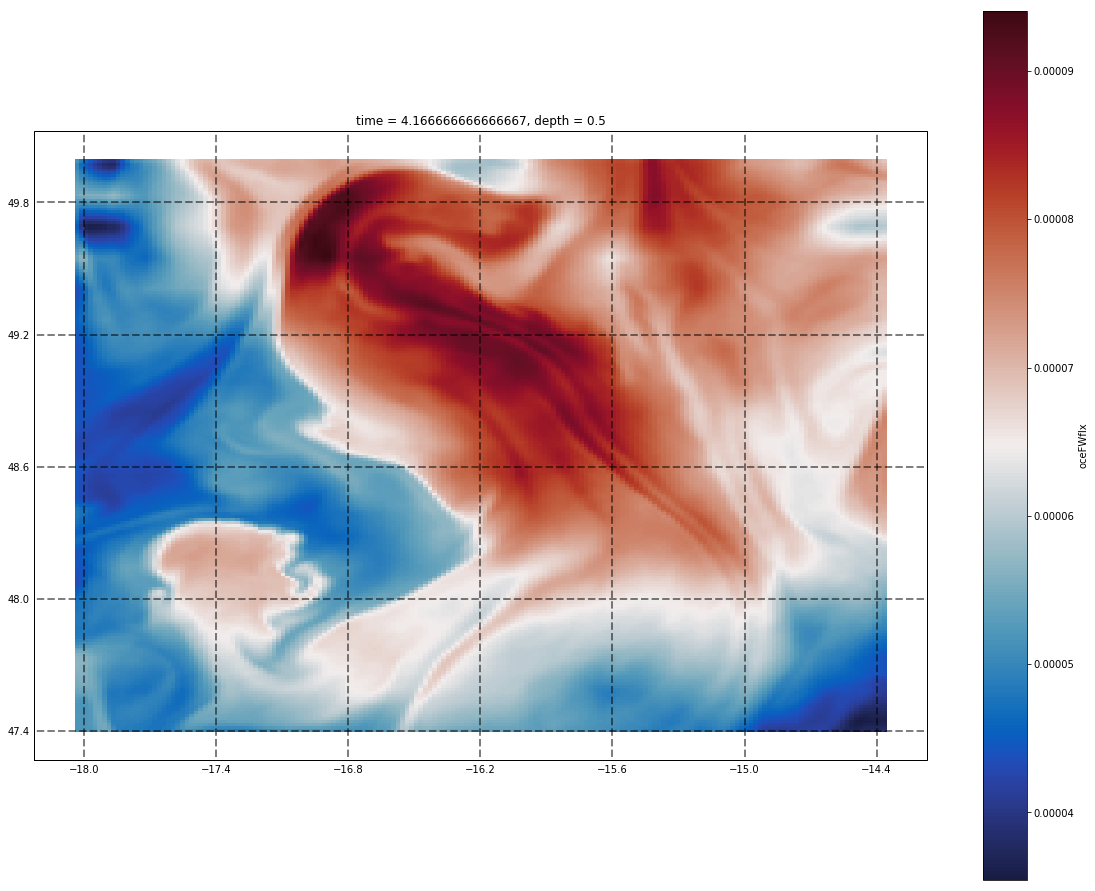

In [25]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_surface.oceFWflx.isel(time=100).plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

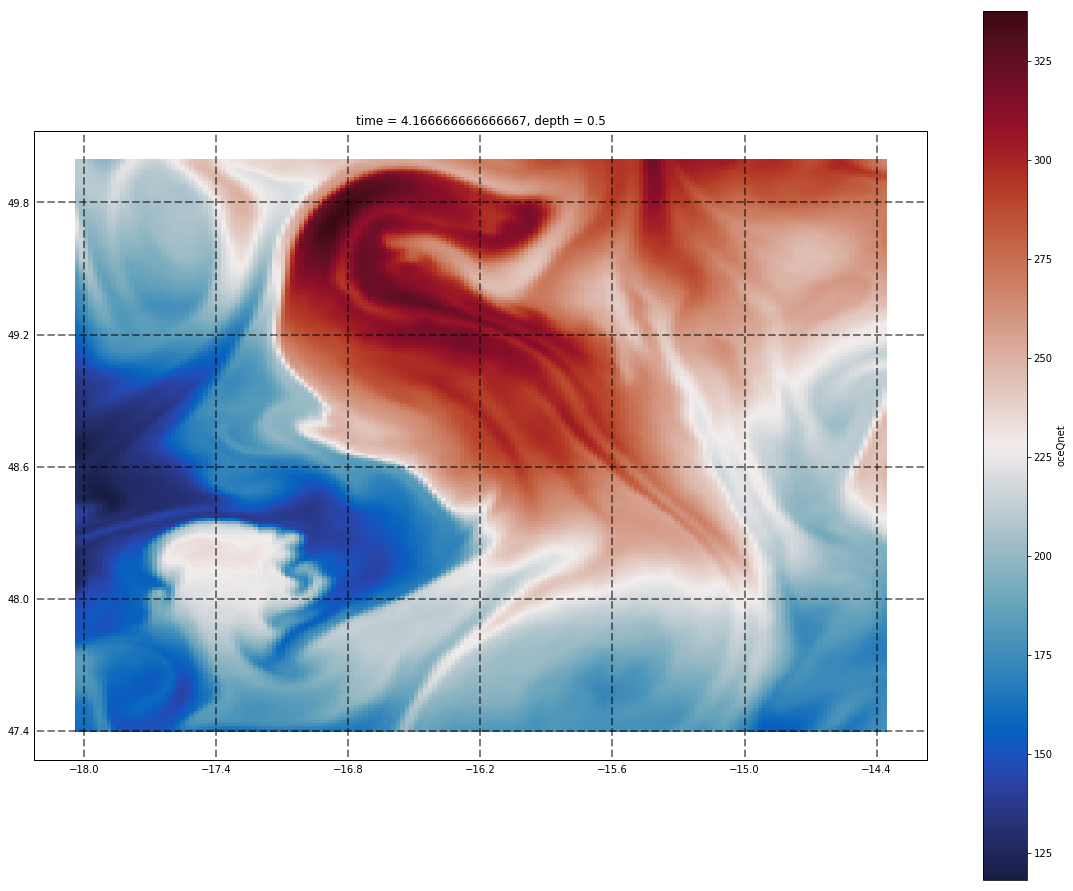

In [26]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_surface.oceQnet.isel(time=100).plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

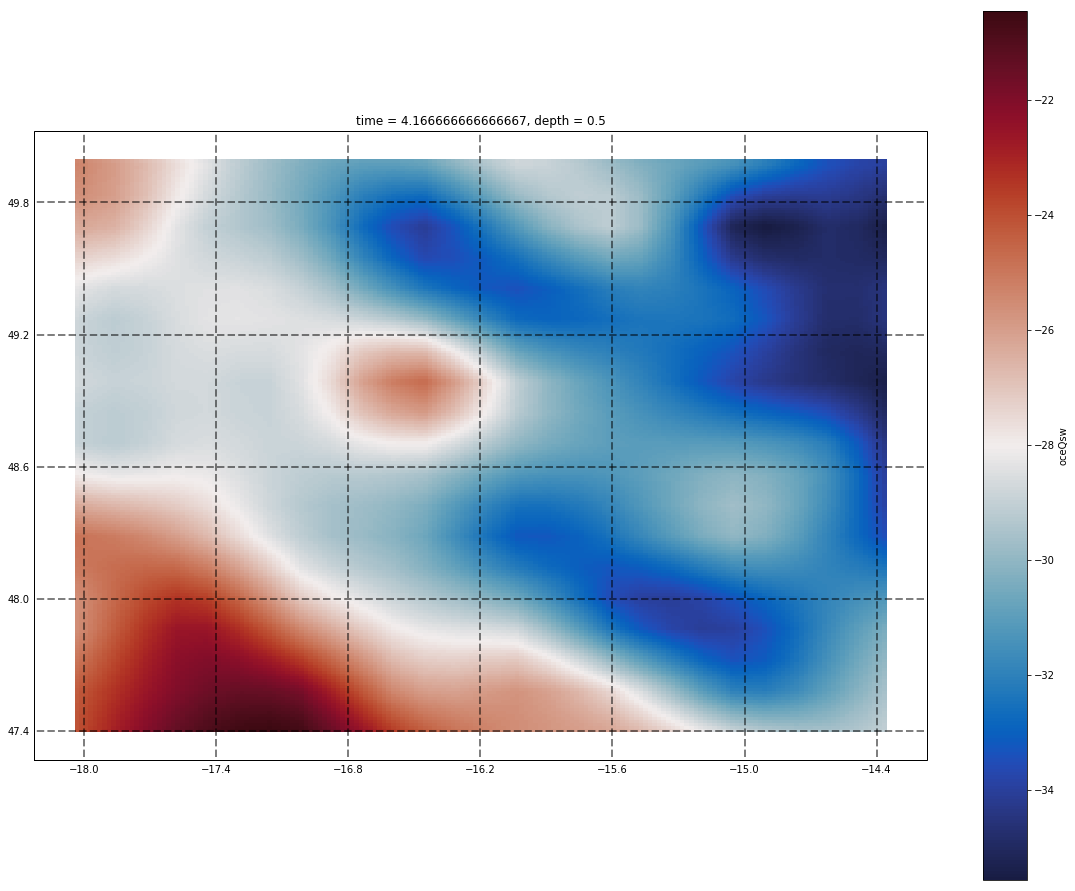

In [27]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_surface.oceQsw.isel(time=100).plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

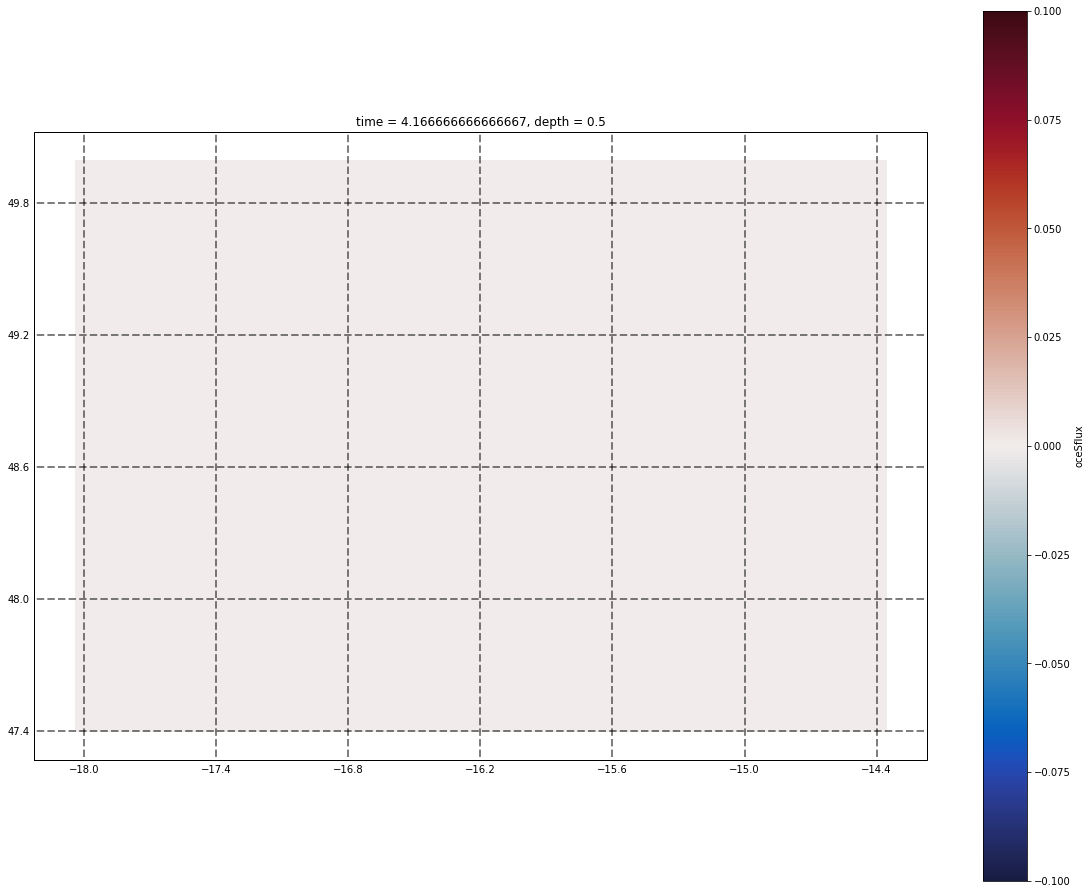

In [28]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_surface.oceSflux.isel(time=100).plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

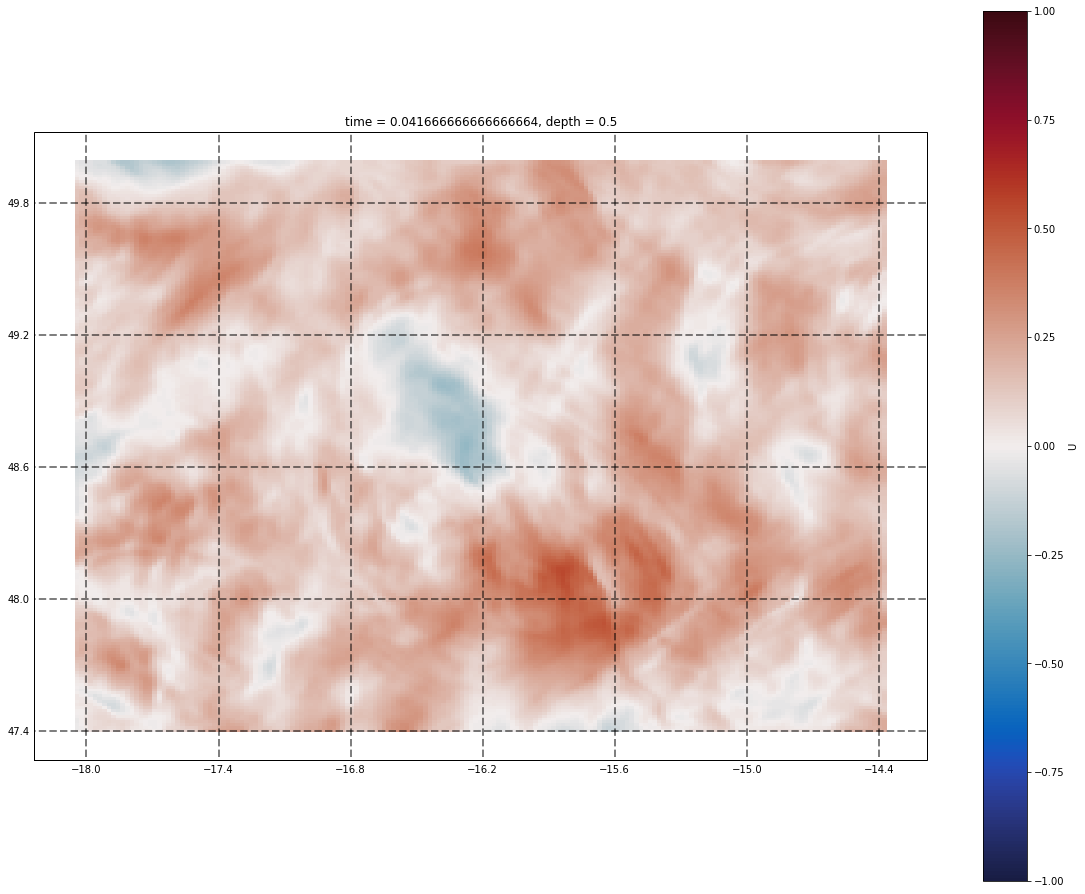

In [17]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_surface.U.isel(time=1).plot.pcolormesh(ax=ax, x='lon_g', y='lat', transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

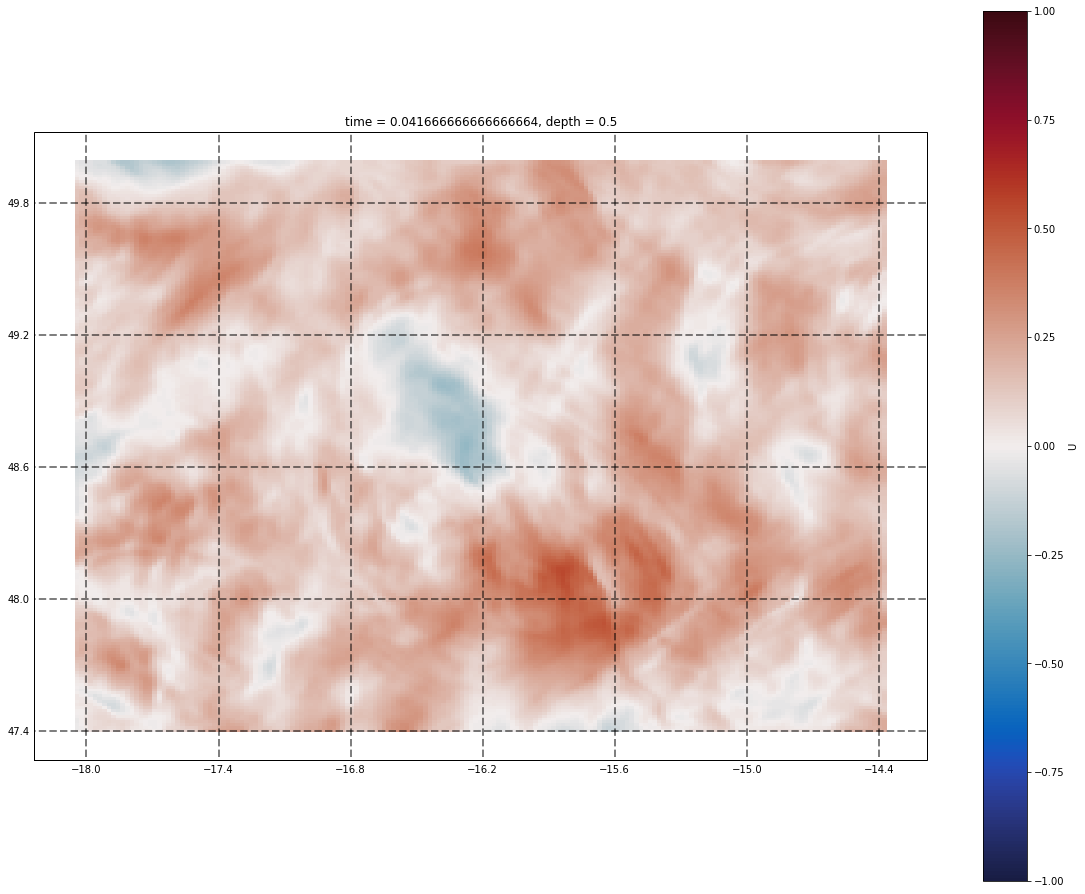

In [17]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_surface.U.isel(time=1).plot.pcolormesh(ax=ax, x='lon_g', y='lat', transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

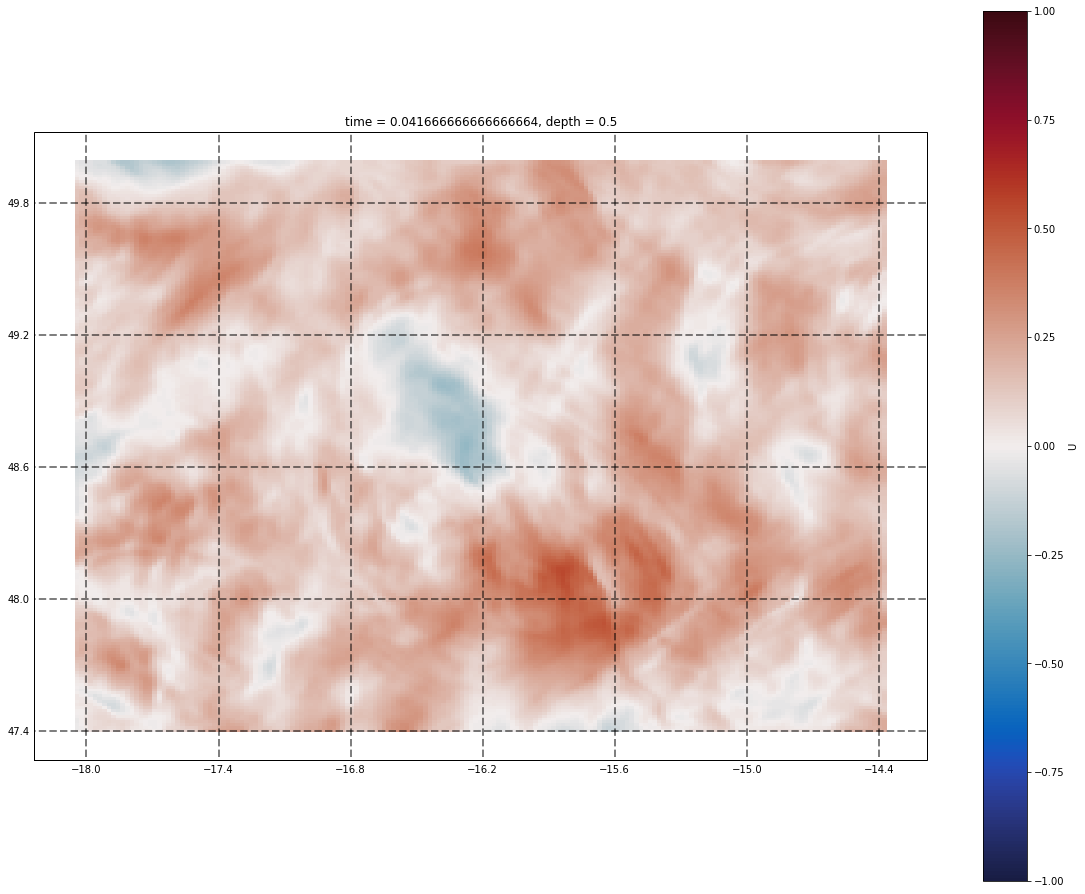

In [17]:
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_surface.U.isel(time=1).plot.pcolormesh(ax=ax, x='lon_g', y='lat', transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

In [31]:
cluster.scheduler.close()

<Future finished result=None>